In [ ]:
!pip install pyJoules[nvidia]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
!pip install keras_flops

In [ ]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from datetime import datetime
from keras_flops import get_flops
from pyJoules.energy_meter import measure_energy
import pandas as pd
import numpy as np
import random
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
# Carregando os dados
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Dividindo o conjunto de treinamento em treinamento e validação
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

# Pré-processando os dados
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')
x_valid = x_valid.reshape(-1, 28, 28, 1).astype('float32')

x_train /= 255
x_test /= 255
x_valid /= 255

n_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, n_classes)

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
model = Sequential()
model.add(Conv2D(32, input_shape=(28, 28, 1), kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        3

In [ ]:
models = []
val_accuracies = []
accuracies = []

for i in range(10):
  print('-------------------------------------------------------------')
  print('modelo ' + str(i+1))
  tempo1 = datetime.now()

  @measure_energy
  def foo():
   return model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(x_valid, y_valid))

  history = foo()

  tempo2 = datetime.now()

  print(f"O tempo de treino em (hh:mm:ss.ms) foi {tempo2-tempo1}")

  media_acc =  np.mean(history.history['accuracy'])
  media_acc_val = np.mean(history.history['val_accuracy'])
  val_accuracies.append(media_acc_val)
  accuracies.append(media_acc_val)
  print(f'Média das acurácias: {media_acc}')
  print(f'Média das acurácias(val): {media_acc_val}')


  flops = get_flops(model, batch_size=128)
  print(f"FLOPS: {flops / 10 ** 9:.03} G")

# Evaluate the model
  val_loss, val_accuracy = model.evaluate(x_valid, y_valid, verbose=0)

 # Store the model and its accuracy
  models.append(model)
  val_accuracies.append(media_acc_val)

mean_accuracy_val = np.mean(val_accuracies)
print(f'Média da Acurácia geral: {mean_accuracy_val}')

# Select the model with the highest accuracy
best_model_index = accuracies.index(max(accuracies))
best_model = models[best_model_index]
print('***********************************')
print('O modelo escolhido para inferência foi o modelo: ' + str(best_model_index+1))

# Use the best model for inference
tempo3 = datetime.now()
y_pred = best_model.predict(x_test)
tempo4 = datetime.now()
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

acuracia = accuracy_score(y_test_classes, y_pred_classes)
precisao = precision_score(y_test_classes, y_pred_classes, average='macro')
recal = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')

print(f'Acurácia: {acuracia}')
print(f'Precisão: {precisao}')
print(f'Recall: {recal}')
print(f'F1-Score: {f1}')

print(f"O tempo de inferência em (hh:mm:ss.ms) foi {tempo4-tempo3}")

-------------------------------------------------------------
modelo 1
Epoch 1/20
375/375 [==============================] - 24s 10ms/step - loss: 0.1784 - accuracy: 0.9432 - val_loss: 0.0627 - val_accuracy: 0.9807
Epoch 2/20
375/375 [==============================] - 3s 7ms/step - loss: 0.0623 - accuracy: 0.9810 - val_loss: 0.0484 - val_accuracy: 0.9849
Epoch 3/20
375/375 [==============================] - 3s 7ms/step - loss: 0.0466 - accuracy: 0.9861 - val_loss: 0.0475 - val_accuracy: 0.9858
Epoch 4/20
375/375 [==============================] - 3s 9ms/step - loss: 0.0382 - accuracy: 0.9887 - val_loss: 0.0574 - val_accuracy: 0.9822
Epoch 5/20
375/375 [==============================] - 3s 7ms/step - loss: 0.0365 - accuracy: 0.9889 - val_loss: 0.0367 - val_accuracy: 0.9893
Epoch 6/20
375/375 [==============================] - 3s 7ms/step - loss: 0.0304 - accuracy: 0.9907 - val_loss: 0.0322 - val_accuracy: 0.9896
Epoch 7/20
375/375 [==============================] - 3s 7ms/step - loss: 0

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPS: 5.67 G
-------------------------------------------------------------
modelo 2
Epoch 1/20
375/375 [==============================] - 3s 7ms/step - loss: 0.0123 - accuracy: 0.9963 - val_loss: 0.0448 - val_accuracy: 0.9894
Epoch 2/20
375/375 [==============================] - 3s 9ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.0386 - val_accuracy: 0.9916
Epoch 3/20
375/375 [==============================] - 3s 7ms/step - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.0390 - val_accuracy: 0.9912
Epoch 4/20
375/375 [==============================] - 3s 7ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.0427 - val_accuracy: 0.9909
Epoch 5/20
375/375 [==============================] - 3s 7ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0434 - val_accuracy: 0.9912
Epoch 6/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0108 - accuracy: 0.9967 - val_loss: 0.0382 - val_accuracy: 0.9915
Epoch 7/20
375/375 [==============================] - 3s 8ms/st

In [ ]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

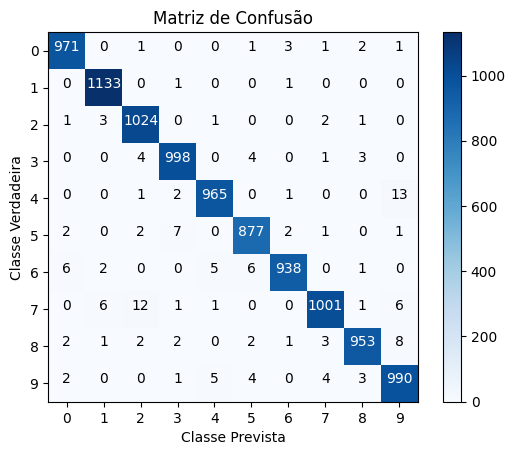

In [ ]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()